# Football Player Recommendation

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

*Prétraitement*

In [9]:
# Lire les données depuis le fichier CSV
valuations = pd.read_csv('dataset/player_valuations.csv', encoding='latin1', delimiter=',')

# Convertir la colonne 'date' en type datetime
valuations['date'] = pd.to_datetime(valuations['date'])

# Trier les données par 'player_id' et 'date' en ordre décroissant
valuations = valuations.sort_values(by=['player_id', 'date'], ascending=[True, False])

# Garder seulement la ligne la plus récente pour chaque 'player_id'
valuations = valuations.drop_duplicates(subset=['player_id'], keep='first')

In [10]:
players = pd.read_csv('dataset/players.csv', encoding='latin1', delimiter=',')

value_df = pd.merge(players, valuations, on='player_id')

value_df = value_df[['name', 'market_value_in_eur_x']]

value_df['market_value_in_eur_x'] = value_df['market_value_in_eur_x'] / 1000000

value_df = value_df.rename(columns={'name': 'Player', 'market_value_in_eur_x': 'Value (in M€)'})

In [11]:
player_df = pd.read_csv('dataset/player_stats_22_23.csv', encoding='latin1', delimiter=';')

df = pd.merge(player_df, value_df, on='Player')

df = df.rename(columns={'Comp': 'League', 'Pos': 'Position', 'Min': 'Minutes played'})

*Gérer les joueurs ayant été transféré au mercato hivernal apparaisant donc deux fois dans le dataset*

In [12]:
# Switch 'Age' and 'Born' columns into string type
df['Age'] = df['Age'].astype(str)
df['Born'] = df['Born'].astype(str)

# If duplicate players, merge them by summing the integer columns and averaging the float columns
int_columns = df.select_dtypes(include='int').columns
float_columns = df.select_dtypes(include='float').columns
string_columns = df.select_dtypes(include='object').columns

agg_funcs = {col: 'sum' for col in int_columns}
agg_funcs.update({col: 'mean' for col in float_columns})
agg_funcs.update({col: 'first' for col in string_columns if col != 'Player'})  # Exclude 'Player' column

df = df.groupby('Player').agg(agg_funcs).reset_index()

*Algorithme de recommandation*

In [13]:
conditions = [['PasAss', 25], ['PasProg', 25], ['TB', 25]]
maximum_age = 22
maximal_value = None
position = None

df_final_filtered = pd.DataFrame()

for condition in conditions:
    attribute = condition[0]
    percentage = condition[1]

    # Calculer le nombre de joueurs à garder
    top_n = int(len(df) * (percentage / 100))
    
    # Trier les joueurs selon l'attribut et garder les top_n
    df_filtered = df.nlargest(top_n, attribute)

    # Ajouter les résultats au DataFrame final
    df_final_filtered = pd.concat([df_final_filtered, df_filtered])

# Filtrer le DataFrame final pour garder seulement les joueurs qui satisfont toutes les conditions
if (len(conditions) > 1):
    df_final_filtered = df_final_filtered.groupby('Player').filter(lambda x: len(x) >= len(conditions))
    df_final_filtered = df_final_filtered.drop_duplicates(subset='Player', keep='first')

# Initialize condition as a boolean Series that represents no condition
condition = pd.Series(True, index=df_final_filtered.index)

# Apply conditions if necessary
if maximum_age is not None:
    condition &= (df_final_filtered['Age'].astype(int) <= maximum_age)
    
if maximal_value is not None:
    condition &= (df_final_filtered['Value (in M€)'] <= maximal_value)

if position is not None:
    condition &= (df_final_filtered['Position'] == position)

# Keep only players with correct condition
df_final_filtered = df_final_filtered.loc[condition]

df_final_filtered = df_final_filtered[['Player', 'Age', 'Squad', 'League', 'Nation', 'Position', 'Value (in M€)', 'Minutes played'] + [cond[0] for cond in conditions]]

print("Nombre de colonnes: " + str(len(df_final_filtered)))

df_final_filtered

Nombre de colonnes: 12


,Player,Age,Squad,League,Nation,Position,Value (in M€),Minutes played,PasAss,PasProg,TB
1384,Rayan Cherki,19,Lyon,Ligue 1,FRA,MFFW,25.0,695,5.06,7.27,0.39
408,Dominik Szoboszlai,22,RB Leipzig,Bundesliga,HUN,MFFW,75.0,1353,2.60,5.27,0.67
168,Arne Engels,19,Augsburg,Bundesliga,BEL,MF,7.5,421,2.55,6.17,0.21
534,Florian Wirtz,19,Leverkusen,Bundesliga,GER,FWMF,100.0,276,2.26,7.10,1.61
245,Callum Hudson-Odoi,22,Leverkusen,Bundesliga,ENG,FWMF,12.0,552,2.13,4.92,0.16
299,Cristian Volpato,19,Roma,Serie A,ITA,MF,5.0,191,1.90,7.14,0.48
1336,Pedri,20,Barcelona,La Liga,ESP,MFFW,90.0,1539,1.87,8.30,0.94
1152,Maxence Caqueret,22,Lyon,Ligue 1,FRA,MF,18.0,1463,1.84,7.06,0.25
345,David Pereira da Costa,22,Lens,Ligue 1,POR,MFFW,6.0,1231,1.75,6.79,0.15
866,Kamory Doumbia,19,Reims,Ligue 1,MLI,MF,2.0,891,1.52,6.16,0.30


*Création de graphs pour illustrer la comparaison de joueurs*

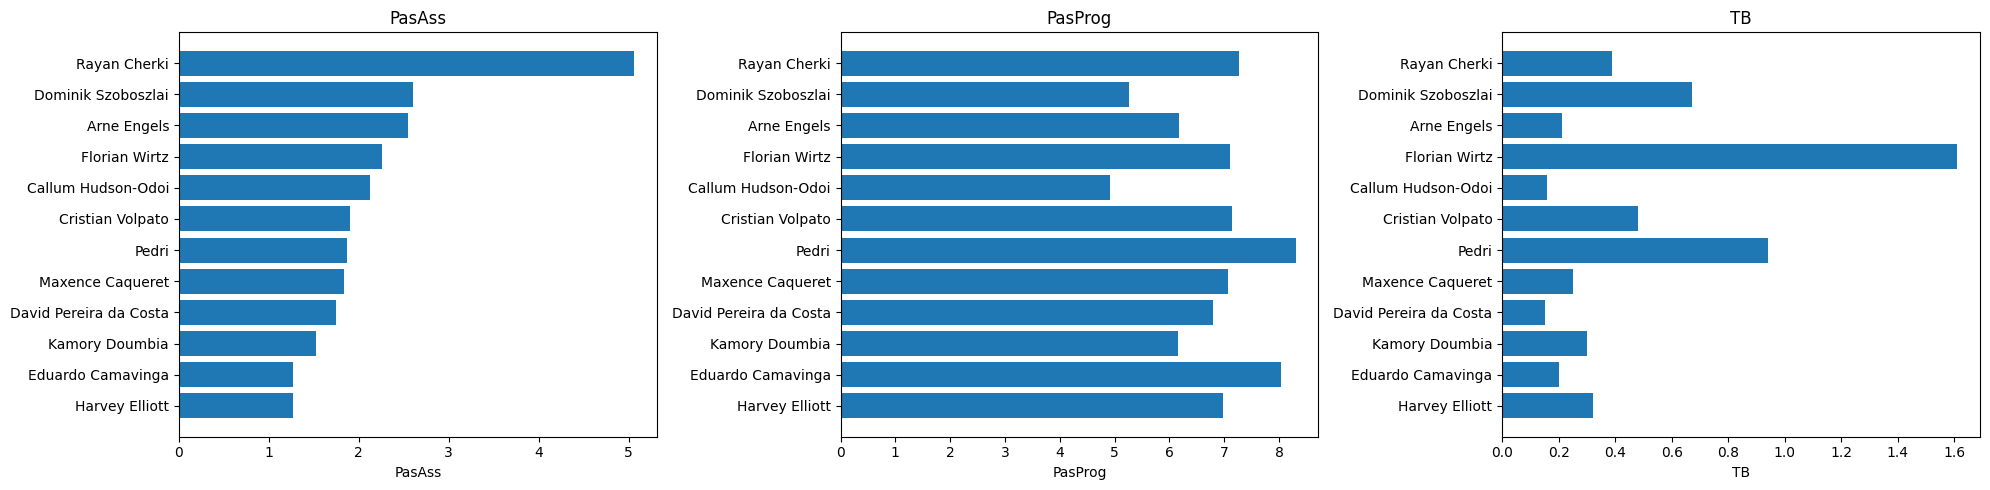

In [14]:
fig, ax = plt.subplots(1, len(conditions), figsize=(20, 5))

for i, condition in enumerate(conditions):
    attribute = condition[0]
    ax[i].barh(df_final_filtered['Player'], df_final_filtered[attribute])
    ax[i].set_title(attribute)
    ax[i].set_xlabel(attribute)
    ax[i].invert_yaxis()

plt.tight_layout()
plt.show()